### Notebook 3

In [32]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import xgboost

scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [33]:
def song_to_df (sp, key):
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    
    row = pd.DataFrame(sp.audio_features(key)).drop(['type','uri',
                                               'track_href','analysis_url'], axis=1).set_index('id')
    return row

def make_genre_prediction(sp,key, ohe, model):
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    row = song_to_df(sp,key)
    temp_ohe = ohe.transform(row[cat_cols])
    returning_obj = row[num_cols].reset_index().join(pd.DataFrame(temp_ohe)).set_index('id')
    return model.predict(returning_obj)

def song_artist_from_key(sp,key):
    theTrack = sp.track(key)
    song_title = theTrack['name']
    artist_title = theTrack['artists'][0]['name']
    song_link = theTrack['external_urls']['spotify']
    return (song_title, artist_title, song_link)


def song_id_from_query(sp, query):
    q = query
    if(sp.search(q, limit=1, offset=0, type='track')['tracks']['total']>0):
        return sp.search( q, limit=1, offset=0, type='track')['tracks']['items'][0]['id']
    else:
        return None

In [34]:
infile = open('pickled_files/all_songs_genre_predicted.pickle','rb')
all_files = pickle.load(infile)
infile.close()
# df.set_index('id', inplace = True)
all_songs = all_files[0]
best_model = all_files[1]
ohe_make_genre_pred = all_files[2]

In [35]:
categorical_columns = list(all_songs.select_dtypes('object').columns)
numerical_columns = list(all_songs.select_dtypes(exclude = 'object').columns)

In [36]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_genre
id,,,,,,,,,,,,,,
2JCHrnxgfagUZQeJRAx7Hc,0.671,0.522,0,-8.144,0,0.0779,0.542000,0.000278,0.3350,0.134,79.975,262533.0,4,hip-hop
2G7woUgHMt6QBU7esQ5rsL,0.564,0.932,11,-10.068,1,0.0554,0.013000,0.169000,0.3490,0.619,112.937,146250.0,4,rock
4eqrNsKy9Mvg1fvfsTVIAE,0.791,0.583,1,-5.247,1,0.3690,0.039300,0.000000,0.0577,0.694,149.693,169147.0,4,hip-hop
5PU9EPOh36Cw0f5VGcAacw,0.458,0.819,0,-5.957,0,0.2630,0.174000,0.000000,0.4070,0.712,83.326,281053.0,4,hip-hop
66ace8nbTVjgHTed107cDn,0.431,0.947,11,-5.067,1,0.0649,0.000027,0.794000,0.3490,0.422,96.243,215627.0,4,alt-metal


In [37]:
import seaborn as sns

In [38]:
# pd.get_dummies(all_songs).corr()

<AxesSubplot:>

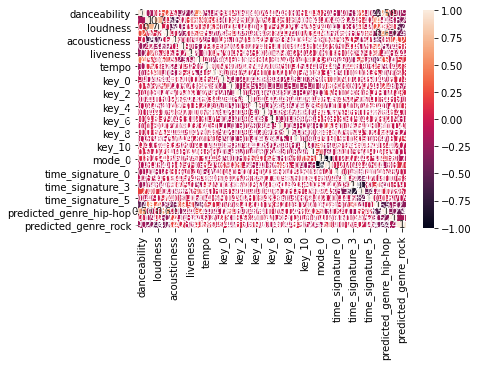

In [39]:
sns.heatmap(pd.get_dummies(all_songs).corr(), annot= True)

In [40]:
len(pd.get_dummies(all_songs).columns)

33

In [41]:
((pd.get_dummies(all_songs).corr()>.75).sum().values).sum()

33

In [42]:
neigh = NearestNeighbors(n_neighbors=10, radius=0.45, metric='cosine')

In [43]:
X_knn = all_songs

In [44]:
MMScaler = preprocessing.MinMaxScaler()
MinMaxScaler = preprocessing.MinMaxScaler()
X_knn[numerical_columns] = MinMaxScaler.fit_transform(X_knn[numerical_columns])


In [45]:
ohe_knn = OneHotEncoder(drop='first', sparse=False)
X_knn_ohe = ohe_knn.fit_transform(X_knn[categorical_columns])
X_knn_transformed = X_knn[numerical_columns].reset_index().join(pd.DataFrame(X_knn_ohe, columns = ohe_knn.get_feature_names(categorical_columns))).set_index('id')


In [46]:
neigh.fit(X_knn_transformed)

NearestNeighbors(metric='cosine', n_neighbors=10, radius=0.45)

In [47]:
categorical_columns

['key', 'mode', 'time_signature', 'predicted_genre']

In [48]:
def knn_preprocessing(sp, key, num_col = numerical_columns, 
                      cat_col = categorical_columns,
                      mmScaler = MinMaxScaler, bm = best_model,
                      ohe_knn = ohe_knn, ohe_make_genre_pred = ohe_make_genre_pred):
    row = song_to_df(sp, key)
    genre = make_genre_prediction(sp,key, ohe_make_genre_pred, bm)
    row['predicted_genre'] = genre[0]
    row_dummied = ohe_knn.transform(row[cat_col])
    row[num_col] = mmScaler.transform(row[num_col])

    row = row[num_col].reset_index().join(pd.DataFrame(row_dummied, columns = ohe_knn.get_feature_names(cat_col))).set_index('id')
    return row

In [49]:
def make_song_recommendations(sp, kneighs, query):
    if(query.isspace() or not query):
        return "No results found"
    song_id = song_id_from_query(sp, query)
    if(song_id == None):
        return "No results found"
    song_plus_artist = song_artist_from_key(sp, song_id)
    song_to_rec = knn_preprocessing(sp, song_id)
    nbrs = neigh.kneighbors(
       song_to_rec, 15, return_distance=False
    )
    playlist = []
    for each in nbrs[0]:
        the_rec_song = song_artist_from_key(sp, X_knn_transformed.iloc[each].name)
        if (((the_rec_song[0:2]) != song_plus_artist[0:2]) and
           ((the_rec_song[0:2]) not in playlist)):
            playlist.append(song_artist_from_key(sp, X_knn_transformed.iloc[each].name))
    return (playlist)

In [50]:
song_id_from_query(sp, "homecoming kanye west")

'2ovQ5MCx91XVjgVWEPfvks'

In [51]:
song_artist_from_key(sp, '2ovQ5MCx91XVjgVWEPfvks')

('Homecoming',
 'Kanye West',
 'https://open.spotify.com/track/2ovQ5MCx91XVjgVWEPfvks')

In [52]:
make_genre_prediction(sp, '2ovQ5MCx91XVjgVWEPfvks', ohe_make_genre_pred, best_model)[0]

'hip-hop'

In [54]:
make_song_recommendations(sp, neigh, "shake it off taylor swift")

[("Really Don't Care",
  'Demi Lovato',
  'https://open.spotify.com/track/5vTPxzm4h2bY9rYyVrGEU5'),
 ("We Didn't Start the Fire",
  'Billy Joel',
  'https://open.spotify.com/track/38bDGWuyYdSdNfrFfbCiVS'),
 ('FBC',
  'Freddie Gibbs',
  'https://open.spotify.com/track/4vsV24dkNq93j2mewVMAS5'),
 ('This Is The Shack',
  'Warren G',
  'https://open.spotify.com/track/0RDpUBXzF6AsCr8gUCXWGK'),
 ('Cash Money Millionaires',
  'Lil Wayne',
  'https://open.spotify.com/track/1tAl34tn79rZn8t1E9EbaN'),
 ('Talk to Me',
  'Run The Jewels',
  'https://open.spotify.com/track/0CBLqGc1esSZ5dM2gOZHsU'),
 ('Dopeman',
  'Mack 10',
  'https://open.spotify.com/track/0ebBL0GkRU2MV373996z8g'),
 ("Let's Get Lost (feat. Devon Baldwin) - Teklife Remix",
  'G-Eazy',
  'https://open.spotify.com/track/0HenVYI9rNIKEgJ3PXtkkS'),
 ('Rhonda',
  'Pastor Troy',
  'https://open.spotify.com/track/48aUzwZD3AbtKDBgcqrz7c'),
 ('The Heat',
  'Lil Wayne',
  'https://open.spotify.com/track/57bIFs9ipfzIHMZYl24OXD'),
 ('I Get Lifted